In [1]:
# Initial setup

%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Import libraries

import cv2
import matplotlib
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact, interactive, interact_manual
import math
import statistics

In [102]:
# Define caminho da imagem
FILEPATH = "img/frames_6/png/"

# 
def analyseImageWithPreview(index, thresh, k_row, k_column):

    global orig, red, th, dst, kernel, dst_open, dst_close, img_height, img_width, cordao
    
    # Define label
    LABEL = "frame_(%.1d).png" %index
    
    # Define nome do arquivo
    FILENAME = FILEPATH + LABEL
    
    print(FILENAME)
    
    # Carregar a imagem na cor BGR (Padrão Opencv)
    orig = cv2.imread(FILENAME, cv2.IMREAD_COLOR)
    
    print(type(orig))
    
    # Cropa imagem pela metade
    h = orig.shape[0]
    #orig = orig[int(h/2):h,:,:]

    # Converter para RGB
    orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
    
    # Define apenas parte vermelha como array de trabalho
    red = orig[:,:,0]
    
    # Define dimensoes da imagem resultante
    img_height, img_width = red.shape
    
    # Filtra imagem utilizando filtro binario (cria dst)
    th, dst = cv2.threshold(red, thresh, 255, cv2.THRESH_BINARY)
    
    # Refina imagem 
    kernel = np.ones((k_row, k_column), np.uint8)    
    dst_open = cv2.morphologyEx(dst, cv2.MORPH_OPEN, kernel)
    
    # Calcula perfil médio da imagem refinada
    avg_profile = averageProfileExtractor(dst_open)
    
    # Salva coordenadas da primeira região em branco [column, rowAvg]
    firstPixel = np.array(firstNonNan(avg_profile))
    
    print(type(firstPixel))
    print(firstPixel)
    
    # Salva coordenadas da última região em branco [column, rowAvg]
    lastPixel = np.array(lastNonNan(avg_profile))
    print(type(lastPixel))
    print(lastPixel)
    
    # Calcula cateto do triângulo formado entre os dois pontos e a horizontal
    cathetus  = lastPixel - firstPixel
    
    # Calcula ângulo de inclinação
    ang = math.atan(cathetus[1]/cathetus[0])*180/np.pi   
    
    # Cria imagem usando função rotate_image
    rotated_image = rotate_image(dst_open, ang)
    
    # Cria perfil médio depois de rotacionar imagem
    avg_profile_rotated = averageProfileExtractor(rotated_image)
    
    # Define linha horizontal
    bead_bottom = np.nanmin(avg_profile_rotated)
    
    # Define altura maxima
    bead_top = np.nanmax(avg_profile_rotated)
    
    # Define altura do maior cordao
    max_bead_height_pixels = bead_top - bead_bottom
    print("Altura do cordao: %.2d" %max_bead_height_pixels)
    
    # Threshold de algura de cordão
    # print(avg_profile_rotated.shape[0])
    
    base = statistics.mode(avg_profile_rotated) + 2
    
    cordao = np.zeros(avg_profile_rotated.shape[0])
    cordao[0] = base
    
    cordao = (avg_profile_rotated > base)
    
    
    tamanho_vetor = 50
    vetores = []
    inicio = 0
    fim = 0
    comecou_cordao = False 

    for index in range(0, cordao.shape[0]-tamanho_vetor):
        
        mudou = False
        p1  = 0
        for x in range(index+1, index+tamanho_vetor):
            if not mudou:
                if cordao[x] != cordao[x-1]:
                    p1 = x
                    mudou = True
            else:
                if cordao[x] != cordao[x-1]:
                    mudou = True
                    cordao[p1:x] = cordao[p1]
        if cordao[index] and not comecou_cordao:
                comecou_cordao = True
                inicio = index        
        else:
            if comecou_cordao == True:
                fim = index
                vetores.append((inicio,fim))
                comecou_cordao = False
    
    print(vetores)
                
        
    
#     for index in range(1, avg_profile_rotated.shape[0]):
#         if avg_profile_rotated[index] == math.nan:
#             cordao[index]=avg_profile_rotated[index-1]
#         if avg_profile_rotated[index] > base:
#             cordao[index]=avg_profile_rotated[index]
#         else:
#             cordao[index]=base    
    
    
    # Plotar imagens
    fig, axes = plt.subplots(3,2, figsize=(12, 8), sharex=True, sharey=True)
    ax = axes.ravel()
    ax[0].imshow(orig)
    ax[1].imshow(red, 'gray')
    ax[2].imshow(dst, 'gray')
    ax[3].imshow(dst_open, 'gray')
    ax[4].plot(avg_profile)
    ax[5].plot(avg_profile_rotated)
    
    
#     plt.figure(figsize = (12,10))
#     plt.hist(avg_profile_rotated, 50)
    
    plt.figure(figsize = (12,4))
    plt.plot(avg_profile_rotated)
    plt.xlim((0,799))
    
    plt.figure(figsize = (12,4))
    plt.plot(cordao)
    plt.xlim((0,799))
    
    plt.figure(figsize = (12,4))
    plt.hist(avg_profile_rotated,30)
    plt.xlim((0,799))
    
    
    
def averageProfileExtractor(img):
    
    global height, width, avg_profile
    
    # Define dimensoes da imagem de entrada
    height, width = img.shape
    
    # Cria array de perfil médio  
    avg_profile = np.array([])
    
    # Loop varrendo cada coluna da imagem de entrada
    for column in range(0, width):
        
        # Array com valor das linhas que contém pixel branco
        column_avg = np.array([])
        
        # Loop em uma coluna adicionando valor da linha de pixels brancos
        for row in range(0, height):
            if img[row,column] > 0:             
                column_avg = np.append(column_avg, row)  
        
        # Adiciona média das linhas ao vetor avg_profile 
        avg_profile = np.append(avg_profile,np.mean(column_avg))     
    
    # Retorna array com perfil médio 
    return avg_profile

## Gira imagem baseado em pixels das bordas

### Função para retornar primeiro item não NaN
def firstNonNan(listfloats):
    for item in range(0,len(listfloats)):
        if math.isnan(listfloats[item]) == False:
            return [item,listfloats[item]]

### Função para retornar último item não NaN
def lastNonNan(listfloats):
    for item in reversed(range(0,len(listfloats))):
        if math.isnan(listfloats[item]) == False:
            return [item,listfloats[item]]

### Função para girar imagem        
def rotate_image(mat, angle):
    # angle in degrees

    height, width = mat.shape[:2]
    image_center = (width/2, height/2)

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)

    abs_cos = abs(rotation_mat[0,0])
    abs_sin = abs(rotation_mat[0,1])

    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    rotation_mat[0, 2] += bound_w/2 - image_center[0]
    rotation_mat[1, 2] += bound_h/2 - image_center[1]

    rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h))
    return rotated_mat
    
# Selecionar imagem apartir da escolha do usuário
interactive(analyseImageWithPreview, index=(0,19), thresh=(0,255), k_row=(1,10), k_column=(1,10))

interactive(children=(IntSlider(value=9, description='index', max=19), IntSlider(value=127, description='thres…

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [43]:
# Define caminho da imagem
FILEPATH = "img/frames_5/png/"

# 
def analyseImageWithPreview(index, thresh, k_row, k_column):

    global orig, red, th, dst, kernel, dst_open, dst_close, img_height, img_width
    
    # Define label
    LABEL = "frame_(%.1d).png" %index
    
    # Define nome do arquivo
    FILENAME = FILEPATH + LABEL
    
    # Carregar a imagem na cor BGR (Padrão Opencv)
    orig = cv2.imread(FILENAME, cv2.IMREAD_COLOR)
    
    # Cropa imagem pela metade
    h = orig.shape[0]
    orig = orig[int(h/2):h,:,:]

    # Converter para RGB
    orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
    
    # Define apenas parte vermelha como array de trabalho
    red = orig[:,:,0]
    
    # Define dimensoes da imagem resultante
    img_height, img_width = red.shape
    
    # Filtra imagem utilizando filtro binario (cria dst)
    th, dst = cv2.threshold(red, thresh, 255, cv2.THRESH_BINARY)
    
    # Refina imagem 
    kernel = np.ones((k_row, k_column), np.uint8)    
    dst_open = cv2.morphologyEx(dst, cv2.MORPH_OPEN, kernel)
    
    # Calcula perfil médio da imagem refinada
    avg_profile = averageProfileExtractor(dst_open)
    
    # Salva coordenadas da primeira região em branco [column, rowAvg]
    firstPixel = np.array(firstNonNan(avg_profile))
    
    # Salva coordenadas da última região em branco [column, rowAvg]
    lastPixel = np.array(lastNonNan(avg_profile))
    
    # Calcula cateto do triângulo formado entre os dois pontos e a horizontal
    cathetus  = lastPixel - firstPixel
    
    # Calcula ângulo de inclinação
    ang = math.atan(cathetus[1]/cathetus[0])*180/np.pi   
    
    # Cria imagem usando função rotate_image
    rotated_image = rotate_image(dst_open, ang)
    
    # Cria perfil médio depois de rotacionar imagem
    avg_profile_rotated = averageProfileExtractor(rotated_image)
    
    # Define linha horizontal
    bead_bottom = np.nanmin(avg_profile_rotated)
    
    # Define altura maxima
    bead_top = np.nanmax(avg_profile_rotated)
    
    # Define altura do maior cordao
    max_bead_height_pixels = bead_top - bead_bottom
    print(max_bead_height_pixels)
    
    # Plotar imagens
    fig, axes = plt.subplots(3,2, figsize=(12, 15), sharex=True, sharey=True)
    ax = axes.ravel()
    ax[0].imshow(orig)
    ax[1].imshow(red, 'gray')
    ax[2].imshow(dst, 'gray')
    ax[3].imshow(dst_open, 'gray')
    ax[4].plot(avg_profile)
    ax[5].plot(avg_profile_rotated)
    
def averageProfileExtractor(img):
    
    global height, width, avg_profile
    
    # Define dimensoes da imagem de entrada
    height, width = img.shape
    
    # Cria array de perfil médio  
    avg_profile = np.array([])
    
    # Loop varrendo cada coluna da imagem de entrada
    for column in range(0, width):
        
        # Array com valor das linhas que contém pixel branco
        column_avg = np.array([])
        
        # Loop em uma coluna adicionando valor da linha de pixels brancos
        for row in range(0, height):
            if img[row,column] > 0:             
                column_avg = np.append(column_avg, row)  
        
        # Adiciona média das linhas ao vetor avg_profile 
        avg_profile = np.append(avg_profile,np.mean(column_avg))     
    
    # Retorna array com perfil médio 
    return avg_profile

## Gira imagem baseado em pixels das bordas

### Função para retornar primeiro item não NaN
def firstNonNan(listfloats):
    for item in range(0,len(listfloats)):
        if math.isnan(listfloats[item]) == False:
            return [item,listfloats[item]]

### Função para retornar último item não NaN
def lastNonNan(listfloats):
    for item in reversed(range(0,len(listfloats))):
        if math.isnan(listfloats[item]) == False:
            return [item,listfloats[item]]

### Função para girar imagem        
def rotate_image(mat, angle):
    # angle in degrees

    height, width = mat.shape[:2]
    image_center = (width/2, height/2)

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)

    abs_cos = abs(rotation_mat[0,0])
    abs_sin = abs(rotation_mat[0,1])

    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    rotation_mat[0, 2] += bound_w/2 - image_center[0]
    rotation_mat[1, 2] += bound_h/2 - image_center[1]

    rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h))
    return rotated_mat
    
# Selecionar imagem apartir da escolha do usuário
interactive(analyseImageWithPreview, index=(0,55), thresh=(0,255), k_row=(1,10), k_column=(1,10))

interactive(children=(IntSlider(value=27, description='index', max=55), IntSlider(value=127, description='thre…

In [15]:
a = np.array([1,2,3,3,3,3,2,2,2])

(array([1., 0., 0., 0., 0., 4., 0., 0., 0., 4.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <a list of 10 Patch objects>)

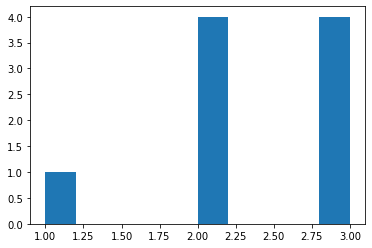

In [17]:
plt.hist(a)

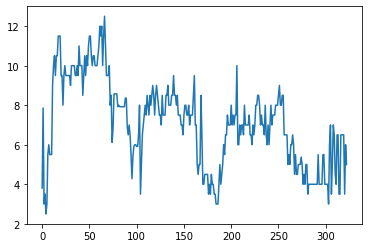

In [4]:
def analyseImageWithoutPreview(index, thresh, k_row, k_column):

    global orig, red, th, dst, kernel, dst_open, dst_close, img_height, img_width
    
    # Define label
    LABEL = "frame_(%.1d).png" %index
    
    # Define nome do arquivo
    FILENAME = FILEPATH + LABEL
    
    # Carregar a imagem na cor BGR (Padrão Opencv)
    orig = cv2.imread(FILENAME, cv2.IMREAD_COLOR)
    
    # Cropa imagem pela metade
    h = orig.shape[0]
    orig = orig[int(h/2):h,:,:]

    # Converter para RGB
    orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
    
    # Define apenas parte vermelha como array de trabalho
    red = orig[:,:,0]
    
    # Define dimensoes da imagem resultante
    img_height, img_width = red.shape
    
    # Filtra imagem utilizando filtro binario (cria dst)
    th, dst = cv2.threshold(red, thresh, 255, cv2.THRESH_BINARY)
    
    # Refina imagem 
    kernel = np.ones((k_row, k_column), np.uint8)    
    dst_open = cv2.morphologyEx(dst, cv2.MORPH_OPEN, kernel)
    
    # Calcula perfil médio da imagem refinada
    avg_profile = averageProfileExtractor(dst_open)
    
    # Salva coordenadas da primeira região em branco [column, rowAvg]
    firstPixel = np.array(firstNonNan(avg_profile))
    
    # Salva coordenadas da última região em branco [column, rowAvg]
    lastPixel = np.array(lastNonNan(avg_profile))
    
    # Calcula cateto do triângulo formado entre os dois pontos e a horizontal
    cathetus  = lastPixel - firstPixel
    
    # Calcula ângulo de inclinação
    ang = math.atan(cathetus[1]/cathetus[0])*180/np.pi   
    
    # Cria imagem usando função rotate_image
    rotated_image = rotate_image(dst_open, ang)
    
    # Cria perfil médio depois de rotacionar imagem
    avg_profile_rotated = averageProfileExtractor(rotated_image)
    
    # Define linha horizontal
    bead_bottom = np.nanmin(avg_profile_rotated)
    
    # Define altura maxima
    bead_top = np.nanmax(avg_profile_rotated)
    
    # Define altura do maior cordao
    max_bead_height_pixels = bead_top - bead_bottom
    
    return max_bead_height_pixels


clad_profile = np.array([])
for i in range(0, 323):
    x = analyseImageWithoutPreview(i, 100, 3, 7)
    clad_profile = np.append(clad_profile, x)

plt.plot(clad_profile)



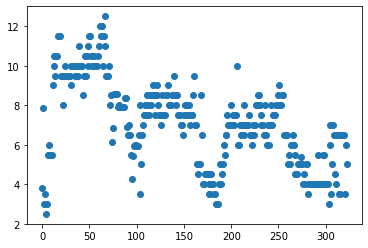

In [5]:
plt.plot(clad_profile,'o')